# Assignment #3 - Spark

*(10 ქულა)*

**ამოცანა #0 - Superheroes' face-off, aka last year's midterm shocker (5 ქულა)**





ეს ზუსტად იგივე ამოცანა, რაც წინა, Pandas-ის დავალებაში გქონდათ. ამჯერად Spark-ზე (და მხოლოდ სპარკზე) უნდა დაწეროთ იგივე, თუმცა, შემდეგი შეზღუდვით: ***არ უნდა გამოიყენოთ loop-ები და არც რეკურსია უშუალოდ მონაცემების მანიპულაციის დროს.*** მაგალითად, **არ შეიძლება**, რომ dataframe-ი subset-ებად დავყოთ და თითოეულ subset-ს for ციკლში სათითაოდ გადაუყვეთ და თითოეული ჯგუფისათვის ჩაატაროთ გარკვეული კალკულაციები. თუმცა, ლამაზი და უფრო დინამიური კოდის წერის მიზნებისათვის, თუკი მხოლოდ DataFrame-ის მეტადატაზე იტერაცია გვჭირდება ან ერთი და იგივე narrow transformation-ის მოდება გვინდა ერთი ან რამდენიმე column-ის ყველა row-ზე, ასეთ შემთხვევებში პითონის list comprehension-ების გამოყენება **დასაშვებია**. მეტი სიცხადითვის, მაგალითები მოცემულია ქვედა პარაგრაფში.

In [1]:
# For Colab only
# !pip install findspark
# !pip install pyspark

# import findspark
# findspark.init()

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

spark = SparkSession \
    .builder \
    .getOrCreate()

data = [('store #0', None, ' ', None, 0),
        ('store #1', 'vake', 'product A', 10.23, 100),
        ('store #1', 'vake', 'product B', 324.2, 200),
        ('store #2', 'saburtalo', 'product A', 10.21, 342),
        ('store #2', 'saburtalo', 'product D', 90.53, 43),
        ('store #3', 'gldani', 'product B', 315.15, 12),
        ('store #3', 'gldani', 'product C', 2.54, 231),
        ('store #4', None, 'product D', 91.31, 20)]

column_names = ['STORE_NAME', 'STORE_LOCATION', 'PRODUCT_NAME', 'PRICE', 'ITEMS_IN_STOCK']
df = spark._sc\
          .parallelize(data)\
          .toDF(column_names)


df.show()

# მაგ. 1 - Column-ების სახელების lowercase-ში გადაყვანა:
def to_lowercase(df, except_cols=None):

  to_lower = [column for column in df.columns if not except_cols or column not in except_cols]

  return df\
          .select(*except_cols, 
                  *[f.col(elem).alias(elem.lower()) for elem in to_lower])

to_lowercase(df, ['STORE_NAME']).show()


# მაგ. 2 - სტრინგად დაკასტული Column-ების კონკატენაცია სეპარატორით:
def concat(df, except_cols=None):

  return df\
          .withColumn('concatenated', f.concat_ws("||", *[f.coalesce(f.col(column).cast('string'), f.lit('used_to_be_null'))
                                                            for column in df.columns if not except_cols or column not in except_cols]))

concat(df, ['STORE_NAME']).show(truncate=False)


''' list comprehension-ების მსგავსად გამოყენება დასაშვებია. ''' 

+----------+--------------+------------+------+--------------+
|STORE_NAME|STORE_LOCATION|PRODUCT_NAME| PRICE|ITEMS_IN_STOCK|
+----------+--------------+------------+------+--------------+
|  store #0|          null|            |  null|             0|
|  store #1|          vake|   product A| 10.23|           100|
|  store #1|          vake|   product B| 324.2|           200|
|  store #2|     saburtalo|   product A| 10.21|           342|
|  store #2|     saburtalo|   product D| 90.53|            43|
|  store #3|        gldani|   product B|315.15|            12|
|  store #3|        gldani|   product C|  2.54|           231|
|  store #4|          null|   product D| 91.31|            20|
+----------+--------------+------------+------+--------------+

+----------+--------------+------------+------+--------------+
|STORE_NAME|store_location|product_name| price|items_in_stock|
+----------+--------------+------------+------+--------------+
|  store #0|          null|            |  null|       

' list comprehension-ების მსგავსად გამოყენება დასაშვებია. '

შეგახსენებთ ამოცანის პირობას:

ამ ამოცანაში მოცემული გაქვთ პატარა dataset Marvel-ისა და DC-ის სუპერგმირების ან supervillain-ების შესახებ. თქვენი მიზანია, სუპერგმირები შემთხვევითობის პრინციპით გადავანაწილოთ სხვადასხვა გუნდებში და თითოეული გუნდისათვის სხვადასხვა კრიტერიუმების დათვლის შემდგომ, გამოვავლინოთ გამარჯვებული გუნდი. 

დატასეტი შემდეგი ფაილებისაგან შედგება:
 - characters_info.csv ფაილში მოცემულია სუპერგმირების ძირითადი მახასიათებლები.
 - character_stats.csv ფაილში მოცემულია დამატებითი სტატისტიკური მონაცემები კონკრეტული სუპერგმირების შესახებ. 
 - superheroes_power_matrix.csv ფაილში კი მოცემულია სუპერგმირებისა და სხვადასხვა სუპერუნარების მატრიცა.

უფრო კონკრეტულად რა მონაცემები და რა field-ები გაქვთ, მარტივად გაარკვევთ უშუალოდ ამ ფაილებიდან.

თქვენი პირველი ამოცანაა, მოცემული სუპერგმირების 5-5 წევრიან გუნდებად გადანაწილებაა. თითოეულ გუნდში აუცილებლად 5 წევრი უნდა იყოს და არ შეიძლება რომელიმე სუპერგმირი ერთზე მეტ გუნდში გვხვდებოდეს. დააგენერირეთ მაქსიმალური შესაძლო რაოდენობის გუნდი. 

გუნდების გენერაციის შემდგომ, თითოეული გუნდისათვის DataFrame-ში column-ებად უნდა განსაზღვროთ:

- team_name: გუნდის სახელი ყველაზე ძლიერი სუპერგმირის მიხედვით ფორმატით "Team: {ყველაზე ძლიერი სუპერგმირის სახელი}". ყველაზე ძლიერი სუპერგმირი არის ის, ვისი შემდეგი ატრიბუტების ჯამი გუნდში ყველაზე მაღალია: Intelligence, Strength, Speed, Durability, Power, Combat.

- leader: იმ სუპერგმირის სახელი, რომლის Intelligence Score-იც გუნდში უმაღლესია. თუ ასეთი რამდენიმეა, აარჩიეთ რომელიმე ერთი.

- tank: გუნდის დარჩენილი წევრებიდან იმ სუპერგმირის სახელი, რომლის Strength-ისა და Durability-ის ჯამიც გუნდში უმაღლესია. თუ ასეთი რამდენიმეა, აარჩიეთ რომელიმე ერთი.

- damage: გუნდის დარჩენილი წევრებიდან იმ სუპერგმირის სახელი, რომლის Speed-ის, Power-ისა და Combat-ის ჯამიც გუნდში უმაღლესია. 

- the_other_guy: გუნდის დარჩენილი წევრებიდან ერთ-ერთი, რომელიც არც leader იყო, არც tank და არც damage.
- the_other_guy2: გუნდის დარჩენილი წევრებიდან ერთ-ერთი, რომელიც არც leader იყო, არც tank, არც damage და არც the_other_guy.

- top_average_speed: გუნდში Top 3 Speed-ის საშუალო. 

- top_average_height: გუნდში Top 3 Height-ის საშუალო.

- flight_count: გუნდის წევრებიდან რამდენს შეუძლია ფრენა.


მას შემდეგ, რაც უკვე ზუსტად ვიცით გუნდების შემადგენლობა, წევრების როლები და მათი შესაძლებლობები, დროა ჩავატაროთ ჩემპიონატი 3 რაუნდად შემდეგი წესებით:

* პირველი რაუნდი არის საკვალიფიკაციო. საკვალიფიკაციო რაუნდში გუნდები შემთხვევითობის პრინციპით ნაწილდებიან 4 ჯგუფში (group ან bucket დავარქვათ). თითოეულ ჯგუფში მაქსიმალურად თანაბარი რაოდენობის გუნდები უნდა მოხვდნენ. თითოეულ ჯგუფში გუნდები თითოჯერ ხვდებიან ერთმანეთს. 

* თითოეულ მატჩში გამარჯვებულს ვადგენთ შემდეგი პრინციპით:
  - გუნდს ეწერება 1 ქულა, თუ მისი top_average_speed აღემატება მეტოქისას. 
  - გუნდს ეწერება 1 ქულა, თუ მისი top_average_height აღემატება მეტოქისას. 
  - გუნდს ეწერება 1 ქულა, თუ მისი flight_count აღემატება მეტოქისას.
  
  ამ კრიტერიუმებით შედარების დროს, თითოეული შედარებისას თუ ფრე მიიღეთ,უპირატესობა მიანიჭეთ იმ გუნდს, რომელსაც უფრო მეტი Peak Human Condition-ის  მქონე წევრები ჰყავს. თუ ამ შემთხვევაშიც ფრეა, ვიყოთ სუბიექტურები და გამარჯვება დავუთმოთ იმ გუნდს, რომელშიც უფრო მეტი კეთილი წევრია (alignment == good). თუ ისევ ფრეა - ქულა დაუწერეთ პირველივე გუნდს (just because. 🦸).

  გამარჯვებული, ცხადია, ისაა, რომელსაც მეტი ქულა ექნება.

* როცა face-off-ებს მოვრჩებით, უნდა დავადგინოთ თითოეული bucket-ის გამარჯვებული. ესაა ის გუნდი, რომელსაც ყველაზე მეტი გამარჯვება აქვს. რამდენიმე გუნდს შორის ფრე თუ დაფიქსირდა, ამ შემთხვევაში იგებს ის გუნდი, რომელსაც Mind Control-ის უნარის მქონე უფრო მეტი წევრი ჰყავს. თუ ისევ ფრე დაფიქსირდა, შეარჩიეთ ნებისმიერი ერთი გუნდი სასურველი პრინციპით ან უბრალოდ შემთხვევითად.

* ჯგუფის ოთხ გამარჯვებულს შორის ვატარებთ ნახევარფინალს შემდეგი პრინციპით: დავასორტიროთ გამარჯვებული გუნდები გამარჯვებების რაოდენობით ზრდადობით. პირველადგილოსანი შეხვდება მეოთხეადგილოსანს, ხოლო მეორე და მესამე ადგილები - ერთმანეთს. შეჯიბრების პრინციპი ზუსტად იგივეა, რაც საკვალიფიკაციო ეტაპზე.

* დასასრულს, ნახევარფინალის გამარჯვებულები ხვდებიან ფინალში ერთმანეთს. ამ შემთხვევაშიც თამაშის წესები უცვლელი რჩება. გამარჯვებულს გადაეცემა 6-ვე Infinity Stone! 💎🤞


იზრუნეთ იმაზე, რომ მონაცემებში არ უნდა გვხვდებოდეს დუბლირებები და არც data loss-ი უნდა იყოს. გაითვალისწინეთ, რომ ყველა საჭირო ინფორმაცია ყველა პერსონაჟისთვის ცნობილი შეიძლება არ იყოს. უარყოფით ან Null ჩანაწერებს მოეპყარით 0-ივით. 


In [2]:
from pyspark.sql.types import DoubleType, BooleanType
from pyspark.sql.functions import udf

# load files into dfs

handle_negatives = udf(lambda n: 0 if (n < 0 or (n is None)) else n, DoubleType())

info = spark.read.option("header", True).csv("../Task 1/characters_info.csv").select("Name", "Height")
info = info.withColumn("Height", info["Height"].cast(DoubleType()))
info = info.withColumn("Height", handle_negatives(info.Height))

stats = spark.read.option("header", True).csv("../Task 1/character_stats.csv")
stats_doubles_cols = ["Intelligence", "Strength", "Speed", "Durability", "Power", "Combat", "Total"]
for col_name in stats_doubles_cols:
    stats = stats.withColumn(col_name, stats[col_name].cast(DoubleType()))
    stats = stats.withColumn(col_name, handle_negatives(getattr(stats, col_name)))
        
powers = spark.read.option("header", True).csv("../Task 1/superheroes_power_matrix.csv").select("Name", "Flight", "Peak Human Condition", "Mind Control")
powers_bool_cols = ["Flight", "Peak Human Condition", "Mind Control"]
for col_name in powers_bool_cols:
    powers = powers.withColumn(col_name, powers[col_name].cast(BooleanType()))

# join the dfs into one df

table = stats.join(info, "Name", "full").join(powers, "Name", "full").fillna(0.0).fillna(False).fillna("")



# delete dfs not being used

del info, stats, powers

table.show()



+-----------------+---------+------------+--------+-----+----------+-----+------+-----+------+------+--------------------+------------+
|             Name|Alignment|Intelligence|Strength|Speed|Durability|Power|Combat|Total|Height|Flight|Peak Human Condition|Mind Control|
+-----------------+---------+------------+--------+-----+----------+-----+------+-----+------+------+--------------------+------------+
|          3-D Man|     good|        50.0|    31.0| 43.0|      32.0| 25.0|  52.0|233.0|   0.0| false|               false|       false|
|           A-Bomb|     good|        38.0|   100.0| 17.0|      80.0| 17.0|  64.0|316.0| 203.0| false|               false|       false|
|       Abe Sapien|     good|        88.0|    14.0| 35.0|      42.0| 35.0|  85.0|299.0| 191.0| false|               false|       false|
|         Abin Sur|     good|        50.0|    90.0| 53.0|      64.0| 84.0|  65.0|406.0| 185.0| false|               false|       false|
|      Abomination|      bad|        63.0|    80

In [3]:
from pyspark.sql.functions import rand, monotonically_increasing_id, row_number
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

# split heroes into teams
# how it's gonna work: 
# shuffle rows to make everything random,
# drop fields to keep hero count a multiple of five,
# each hero get's assigned to a team based on row_num (row_num // 5)

table = table.orderBy(rand()).limit(table.count() - table.count() % 5)

team_num_udf = udf(lambda row_num: row_num // 5)

table = table.withColumn("row_num", monotonically_increasing_id())
table = table.withColumn("team_num", team_num_udf(table.row_num))

table = table.withColumn("team_num", table["team_num"].cast(IntegerType()))

table = table.drop("row_num")

table.show()

+--------------+---------+------------+--------+-----+----------+-----+------+-----+------+------+--------------------+------------+--------+
|          Name|Alignment|Intelligence|Strength|Speed|Durability|Power|Combat|Total|Height|Flight|Peak Human Condition|Mind Control|team_num|
+--------------+---------+------------+--------+-----+----------+-----+------+-----+------+------+--------------------+------------+--------+
|   Hellgramite|         |         0.0|     0.0|  0.0|       0.0|  0.0|   0.0|  0.0|   0.0| false|               false|       false|       0|
|Jack of Hearts|     good|        63.0|    55.0|100.0|      30.0| 70.0|  30.0|348.0| 155.0|  true|               false|       false|       0|
|        Moloch|      bad|         1.0|     1.0|  1.0|       1.0|  0.0|   1.0|  5.0|   0.0| false|               false|       false|       0|
|       Bizarro|  neutral|        75.0|    95.0|100.0|     100.0| 95.0|  85.0|550.0| 191.0|  true|               false|       false|       0|
|     

In [4]:
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
from pyspark.sql.functions import col, expr


w = Window.partitionBy("team_num")
w_team_selection = w.orderBy("Name")

# team name
teams = table.withColumn("max_total", expr("max(Total)").over(w))\
    .filter(col("Total") == col("max_total"))\
    .withColumn("row_number", row_number().over(w_team_selection))\
    .filter(col("row_number") <= 1)\
    .drop("row_number")\
    .select("team_num", expr("concat('Team: ', Name) as team_name"))

# leader
teams = teams.join(table.withColumn("max_intel", expr("max(Intelligence)").over(w))\
    .filter(col("Intelligence") == col("max_intel"))\
    .withColumn("row_number", row_number().over(w_team_selection))\
    .filter(col("row_number") <= 1)\
    .drop("row_number")\
    .select("team_num", expr("Name as leader")), "team_num", "full")\

already_picked = teams.select(expr("leader as name"))


# tank
teams = teams.join(table.join(already_picked, table["Name"] == already_picked["name"], "left_anti")\
    .withColumn("max_tank", expr("max(Strength + Durability)").over(w))\
    .filter(expr("Strength + Durability") == col("max_tank"))\
    .withColumn("row_number", row_number().over(w_team_selection))\
    .filter(col("row_number") <= 1)\
    .drop("row_number")\
    .select("team_num", expr("Name as tank")), "team_num", "full")

already_picked = already_picked.union(teams.select(col("tank")).toDF("name"))


# damage
teams = teams.join(table.join(already_picked, table["Name"] == already_picked["name"], "left_anti")\
    .withColumn("max_damage", expr("max(Speed + Power + Combat)").over(w))\
    .filter(expr("Speed + Power + Combat") == col("max_damage"))\
    .withColumn("row_number", row_number().over(w_team_selection))\
    .filter(col("row_number") <= 1)\
    .drop("row_number")\
    .select("team_num", expr("Name as damage")), "team_num", "full")

already_picked = already_picked.union(teams.select(col("damage")).toDF("name"))


# other_guy
teams = teams.join(table.join(already_picked, table["Name"] == already_picked["name"], "left_anti")\
    .withColumn("row_number", row_number().over(w_team_selection))\
    .filter(col("row_number") <= 1)\
    .drop("row_number")\
    .select("team_num", expr("Name as other_guy")), "team_num", "full")

already_picked = already_picked.union(teams.select(col("other_guy")).toDF("name"))

# other_guy_2
teams = teams.join(table.join(already_picked, table["Name"] == already_picked["name"], "left_anti")\
    .select("team_num", expr("Name as other_guy2")), "team_num", "full")     

teams = teams.drop("row_num")



teams.show()

+--------+--------------------+--------------+---------------+---------------+--------------+---------------+
|team_num|           team_name|        leader|           tank|         damage|     other_guy|     other_guy2|
+--------+--------------------+--------------+---------------+---------------+--------------+---------------+
|       0|       Team: Bizarro|       Bizarro| Jack of Hearts|         Moloch|   Hellgramite|      Parademon|
|       1|   Team: General Zod|   General Zod|        Thundra|     Blizzard I|    Donna Troy|    Plastic Lad|
|       2|  Team: Master Chief|  Master Chief|  Luke Campbell|   Renata Soliz|   Black Flash|   Mister Zsasz|
|       3|         Team: Toxin|     Daredevil|          Toxin|    Shadow King|      Hit-Girl|           Husk|
|       4|  Team: Doppelganger|       Ant-Man|   Doppelganger|Invisible Woman|Brother Voodoo|       Siren II|
|       5|         Team: Cable|         Cable|    Plastic Man|       Deathlok|         Alien|           Odin|
|       6|

In [5]:
from pyspark.sql.functions import avg, round

w_speed = w.orderBy(col("Speed").desc())
w_height = w.orderBy(col("Height").desc())

top_avg_speed = table.withColumn("speed_rank", row_number().over(w_speed))\
    .filter(col("speed_rank") <= 3)\
    .withColumn("row_number", row_number().over(w_team_selection))\
    .filter(col("row_number") <= 3)\
    .select("team_num", "Speed")\
    .groupBy("team_num").avg("Speed").withColumnRenamed("avg(Speed)", "top_avg_speed")\
    .withColumn("top_avg_speed", round(col("top_avg_speed").cast(DoubleType()), 1))

top_avg_height = table.withColumn("height_rank", row_number().over(w_height))\
    .filter(col("height_rank") <= 3)\
    .withColumn("row_number", row_number().over(w_team_selection))\
    .filter(col("row_number") <= 3)\
    .select("team_num", "Height")\
    .groupBy("team_num").avg("Height").withColumnRenamed("avg(Height)", "top_avg_height")\
    .withColumn("top_avg_height", round(col("top_avg_height").cast(DoubleType()), 1))

teams = teams.join(top_avg_speed, "team_num", "full").join(top_avg_height, "team_num", "full")

teams.show()

+--------+--------------------+--------------+---------------+---------------+--------------+---------------+-------------+--------------+
|team_num|           team_name|        leader|           tank|         damage|     other_guy|     other_guy2|top_avg_speed|top_avg_height|
+--------+--------------------+--------------+---------------+---------------+--------------+---------------+-------------+--------------+
|       0|       Team: Bizarro|       Bizarro| Jack of Hearts|         Moloch|   Hellgramite|      Parademon|         67.0|         115.3|
|       1|   Team: General Zod|   General Zod|        Thundra|     Blizzard I|    Donna Troy|    Plastic Lad|         43.0|         131.0|
|       2|  Team: Master Chief|  Master Chief|  Luke Campbell|   Renata Soliz|   Black Flash|   Mister Zsasz|         12.3|          71.0|
|       3|         Team: Toxin|     Daredevil|          Toxin|    Shadow King|      Hit-Girl|           Husk|         44.0|         186.3|
|       4|  Team: Doppelgan

In [6]:
from pyspark.sql.functions import count

flight_cnt = table.select("team_num", "Flight").filter(col("Flight"))\
    .groupBy("team_num").count().withColumnRenamed("count", "flight_cnt").orderBy("team_num")

phc_cnt = table.select("team_num", "Peak Human Condition").filter(col("Peak Human Condition"))\
    .groupBy("team_num").count().withColumnRenamed("count", "phc_cnt").orderBy("team_num")

mc_cnt = table.select("team_num", "Mind Control").filter(col("Mind Control"))\
    .groupBy("team_num").count().withColumnRenamed("count", "mc_cnt").orderBy("team_num")

is_good = udf(lambda a: True if a=="good" else False, BooleanType())

good_cnt = table.select("team_num", "Alignment").filter(is_good(col("Alignment")))\
    .groupBy("team_num").count().withColumnRenamed("count", "good_cnt").orderBy("team_num")

teams_attrs = teams.select("team_num", "team_name")\
    .join(flight_cnt, "team_num", "left")\
    .join(phc_cnt, "team_num", "left")\
    .join(mc_cnt, "team_num", "left")\
    .join(good_cnt, "team_num", "left")\
    .fillna(0)

teams_attrs.show()

teams_attrs


+--------+--------------------+----------+-------+------+--------+
|team_num|           team_name|flight_cnt|phc_cnt|mc_cnt|good_cnt|
+--------+--------------------+----------+-------+------+--------+
|       0|       Team: Bizarro|         3|      0|     0|       1|
|       1|   Team: General Zod|         2|      0|     0|       3|
|       2|  Team: Master Chief|         1|      0|     0|       2|
|       3|         Team: Toxin|         0|      0|     0|       5|
|       4|  Team: Doppelganger|         0|      0|     0|       3|
|       5|         Team: Cable|         1|      0|     1|       3|
|       6|Team: Doctor Octopus|         1|      1|     0|       0|
|       7|       Team: Impulse|         2|      0|     0|       3|
|       8|       Team: Kilowog|         0|      0|     0|       3|
|       9|    Team: Alan Scott|         1|      1|     0|       5|
|      10|     Team: Chameleon|         1|      0|     1|       2|
|      11|Team: Blue Beetle...|         1|      0|     0|     

DataFrame[team_num: int, team_name: string, flight_cnt: bigint, phc_cnt: bigint, mc_cnt: bigint, good_cnt: bigint]

In [7]:
group_size = (teams_attrs.count()//4) + 1

group_num_udf = udf(lambda row_num: row_num // group_size)

group_nums = teams_attrs.select("team_num").orderBy(rand())\
    .withColumn("row_num", monotonically_increasing_id())

group_nums = group_nums.withColumn("group_num", group_num_udf(group_nums.row_num))

teams_attrs = teams_attrs.join(group_nums, "team_num", "full")

teams_attrs.show()



+--------+--------------------+----------+-------+------+--------+-------+---------+
|team_num|           team_name|flight_cnt|phc_cnt|mc_cnt|good_cnt|row_num|group_num|
+--------+--------------------+----------+-------+------+--------+-------+---------+
|       0|       Team: Bizarro|         3|      0|     0|       1|     96|        2|
|       1|   Team: General Zod|         2|      0|     0|       3|    123|        3|
|       2|  Team: Master Chief|         1|      0|     0|       2|    132|        3|
|       3|         Team: Toxin|         0|      0|     0|       5|    106|        2|
|       4|  Team: Doppelganger|         0|      0|     0|       3|     90|        2|
|       5|         Team: Cable|         1|      0|     1|       3|    110|        2|
|       6|Team: Doctor Octopus|         1|      1|     0|       0|     82|        2|
|       7|       Team: Impulse|         2|      0|     0|       3|     98|        2|
|       8|       Team: Kilowog|         0|      0|     0|       3

**ამოცანა #1 - Slowly Changing Dimension Type 2 (SCD2) (5 ქულა)**

თუკი ტერმინი Slowly Changing Dimension (მითუმეტეს Type 2) არაფერს არ გეუნებათ ან ბუნდოვნად გახსოვთ, გირჩევთ, ყურადღებით გადახედოთ მეორე კვირის Data Warehousing-ის სლაიდებს: [სლაიდები](https://classroom.google.com/c/NTQ4MTc4Nzk1MzY3/m/NTQ5NzM2Mjk5MjY1/details)  

აქვეც შეგახსენებთ SCD2-ის პრინციპს:

დავუშვათ, ჩვენს მონაცემთა საცავში გვაქვს შემდეგი ისტორიული ცხრილი, სადაც მონაცემები არის შენახული დაწყებული 01-01-2022-დან 01-05-2022-ის ჩათვლით:

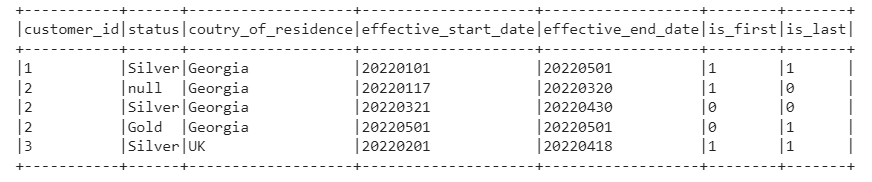


ამ მონაცემებს დავარქვათ Existing data, სადაც თითოეული customer-ის შესახებ ცვლილებების ისტორია ინახება.
ამ ცხრილში ბოლო ოთხი ველი არის ტექნიკური ხასიათის:
  - ეფექტურობის თარიღები (effective_start_date / effective_end_date) აღნიშნავს, საიდან სადამდე იყო ჩანაწერი უცვლელი.
  - is_first - ამ ველში 1-ით მონიშნულია თითოეულ customer-ზე სულ პირველი ჩანაწერი. 
  - is_last - ამ ველში 1-ით მონიშნულია თითოეულ customer-ზე ყველაზე უკანასკნელი ჩანაწერი. 


გაითვალისწინეთ, რომ:
 - ამ ცხრილში უნიკალურია customer_id-ისა და effective start/end date-ების კომბინაციია. 
 - ზემოთ მოყვანილ ცხრილში რომ შევხედოთ customer #1-ს, ვნახავთ, რომ 1 იანვრიდან 1 მაისის ჩათვლით მის შესახებ არაფერი არ შეცვლილა. შესაბამისად, მის შესახებ ერთადერთი record არის ჩვენს ცხრილში, რომელსაც ერთდროულად is_first-სა და is_last ველებში 1-იანი უწერია. რაც შეეხება customer #2-ს, ვნახავთ, რომ მასზე რამდენიმე ცვლილებაა დაგენერირებული, თუმცა is_first = 1 უწერია მხოლოდ ყველაზე ძველ ჩანაწერს, ხოლო is_last = 1 უწერია მხოლოდ ყველაზე უახლესს ჩანაწერს. რაც შეეხება customer #3-ს, როგორც ჩანს, მან ანგარიში დახურა 18 აპრილს და ამ თარიღის შემდეგ მის შესახებ აღარაფერი გვსმენია. შესაბამისად, ყველაზე ახალი ჩანაწერი ამ კლიენტზე გვაქვს 20220418-ის მდგომარობით და სწორედ ამ ჩანაწერს ვუწერთ is_last-ში 1-ს.

ეს ტექნიკური ველები არის სწორედ Change Detection პროცესის შედეგად დაგენერირებული. ამ დავალების მიზანი მონაცემებში ცვლილებების დაჭერა და ამ ველების სწორი გენერაციაა.

დავუშვათ, დადგა ამავე ცხრილში მომდევნო დღის (02-05-2022) მონაცემების ჩაწერის დრო. ამ მონაცემებს New data-ს ვეძახით ხოლმე. დავუშვათ, 02-05-2022-ის მდგომარეობით მონაცემები ასე გამოიყურება:




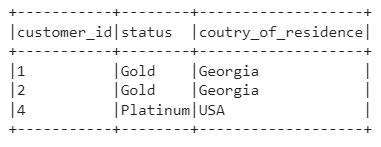


თუ დავაკვირდებით:
  - customer #1-ს Silver სტატუსი ჰქონდა 1 მაისამდე, მაგრამ გახდა Gold 2 მაისიდან დაწყებული.
  - customer #2-ზე არაფერი შეცვლილა.
  - customer #4 საერთოდ ახალი მომხმარებელია.


New data-ს existing-თან გაერთიანების შედეგად კი საბოლოოდ ასეთი სურათი უნდა მივიღოთ:

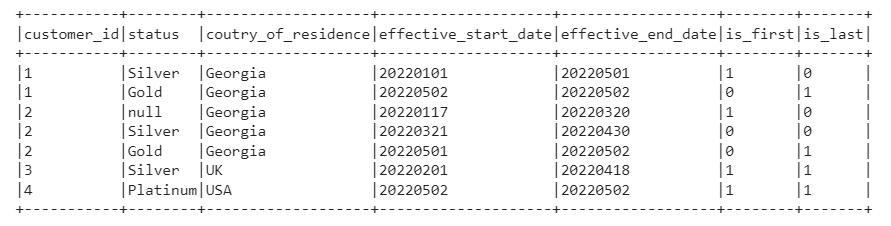



აღნიშნული მაგალითი SCD2-ის პროცესინგის ერთ-ერთი ყველაზე მარტივი ქეისია. ამ დავალებაში მოცემული გექნებათ უფრო რთული ორი ალტერნატივა, თუმცა მაქსიმალური ქულის მისაღებად ამ ორიდან თქვენ მიერ შერჩეული **მხოლოდ ერთის** ამოხსნა არის საჭირო. ორივე ალტერნატივა ისევ SCD2 ტიპის ცხრილებს ეხება. თითოეულისათვის საჭირო dataset მოცემული გაქვთ თანდართულ CSV ფაილებში.

**Option #1: Change Detection for Multiple Days**

- მოცემული გაქვთ Existing Data თანამშრომლების შესახებ 19-08-2014-ის მდგომარეობით (ანუ უახლესი მონაცემები ამ რიცხვით თარიღდება). ასევე, მოცემული გაქვთ New Data რამდენიმე დღისათვის (20-31 აგვისტო). ამ შუალედში თითოეული დღის ჭრილში თითოეულ თანამშრომელზე მოდის ინფორმაცია. თქვენი მიზანია, დაიჭიროთ ცვლილებები (როგორც Existing-თან, ასევე New data-ს თითოეულ დღესთან მიმართებაში) და SCD2 პრინციპით შეკუმშოთ მონაცემები. 

  ამოცანა, ფაქტობრივად, ზუსტად იგივეა, რაც ზემოთ განხილულ მაგალითში, თუმცა საქმეს ართულებს ის, რომ ერთდროულად რამდენიმე დღის change datection-ს აკეთებთ. აუცილებელი მოთხოვნაა, რომ არც აქ გამოიყენოთ loop-ები: მთლიანი new data ერთდროულად უნდა შეკუმშოთ და არ უნდა დახლიჩოთ მიმდევრობით ოპერაციებად (მაგალითად, loop-ის გამოყენებით ჯერ რომ 20 აგვისტოს data დაგემუშავებინათ, მერე 21-ის და ა. შ.). ამ ალტერნატივისათვის საჭირო ფაილებია:
    - Option 1 Existing.csv
    - Option 1 New.csv
    - Option 1 Result.csv - გამოყენება არსად დაგჭირდებათ, მაგრამ აქ მოცემულია, საბოლოო შედეგი როგორ უნდა გამოიყურებოდეს.

**Option #2: Multi-Row Change Detection**

-  ამ შემთხვევაში, მართალია, ისევ SCD2 ტიპის ცხრილზეა საუბარი, მაგრამ აქ მონაცემებია უფრო რთული სტრუქტურის და უფრო რთულდება მონაცემების ცვლილებების აღმოჩენა. კერძოდ, Existing Data-დ მოცემული გაქვთ სესხების გრაფიკები. ჩვენს შემთხვევაში გრაფიკი არის კალენდარი, სადაც სათითაო row-დ ჩამოწერილია, რა თარიღებში უწევს ამ სესხს ყოველთვიური გადახდები (ანუ გრაფიკი შედგება ერთზე მეტი ჩანაწერისაგან). თითოეულ სესხს გააჩნია ერთი გრაფიკი, რომელიც შეიძლება შეიცვალოს. მაგალითად, თუ მომხმარებელს ჰქონდა 1-წლიანი სესხი, შეიძლება მოითხოვოს და ეს პერიოდი გაზარდოს ან შეამციროს. შესაბამისად, გრაფიკიც შეეცვლება.
   გრაფიკების ცვლილებების ისტორიაც, გვინდა, რომ SCD2-ად შევინახოთ. ამიტომ Existing-თან ერთად მოცემული გაქვთ New Data-ც მხოლოდ ერთი დღისათვის, რომელიც ზემოთ აღნიშნული პრინციპით უნდა შეკუმშოთ. New Data-შიც სესხზე (არსებულებზე ან ახლებზე) სრული გრაფიკი მოდის. გამომდინარე იქიდან, რომ გრაფიკი რამდენიმე ჩანაწერისაგან შედგება, ფაქტობრივად, გვიწევს რამდენიმე ჩანაწერის რამდენიმე ჩანაწერთან დადარება (სიმრალეების შედარება) იმისათვის, რომ გავიგოთ, თითოეული სესხისათვის გრაფიკი შეიცვალა თუ არა. აქაც ვაგენერირებთ ველებს effective_start_date, effective_end_date, is_first, is_last. 

   ამ ალტერნატივისათვის საჭირო ფაილებია:
    - Option 2 Existing.csv
    - Option 2 New.csv
    - Option 2 Result.csv - გამოყენება არსად დაგჭირდებათ, მაგრამ აქ მოცემულია, საბოლოო შედეგი როგორ უნდა გამოიყურებოდეს.
    - Option 2.xlsx - existing, new და result-ებია მოცემული სხვადასხვა sheet-ზე,სადაც ერთი და იგივე გრაფიკებია ერთ ფერად მონიშნული. ეს, ვფიქრობთ, რომ ამოცანის გააზრებაში დაგეხმარებათ.

მესამე ალტერნატივად შეგიძლიათ განიხილოთ ყველაზე მარტივი ქეისი, ანუ ისეთივე, რაც ამ დავალების პირობაშივე იყო აღწერილი. ამ ალტერნატივისათვის მოწოდებული გაქვთ Option 3-ის csv ფაილები (existing, new, result), სადაც თანამშრომლების შესახებ ინფორმაციაა. აკეთებთ Change Detection-ს მხოლოდ ერთი დღისთვის. ცხრილის სტრუქტურაც მარტივია: ერთი თანამშრომლის შესახებ მთელი ინფორმაცია ერთ row-ად არის ყოველ თვის წარმოდგენილი. თუმცა, გაითვალისწინეთ, თუ ამ option-ს აირჩევთ, საუკეთესო შემთხვევაში მიიღებთ მხოლოდ ამ ამოცანის მაქსიმალური ქულის ნახევარს.

კვლავ შეგახსენებთ, რომ უნდა დაწეროთ ზემოთჩამოთვლილი ალტერნატივებიდან **მხოლოდ ერთი**. თუ ორივე ან სამივე option-ის დაწერას გადაწყვეტთ, ეგ ჩაითვლება extension-ად და შეფასდება ბონუს ქულებით.

ასე რომ, გაქვთ ბევრი ალტერნატივა. ამიტომ ყურადღებით გაეცანით მოწოდებულ ფაილებს, option-ებს და choose wisely!

In [8]:
existing = spark.read.option("header", True).csv("../Task 2/Option 1 Existing.csv")
new = spark.read.option("header", True).csv("../Task 2/Option 1 New.csv")



In [9]:
from pyspark.sql.functions import to_date, col
from pyspark.sql.types import DateType

existing = existing.withColumn("employement_start_date", to_date(col("employement_start_date"), "yyyyMMdd" ))\
    .withColumn("employement_end_date", to_date(col("employement_end_date"), "yyyyMMdd" ))\
    .withColumn("effective_start_date", to_date(col("effective_start_date"), "yyyyMMdd"))\
    .withColumn("effective_end_date", to_date(col("effective_end_date"), "yyyyMMdd"))\
    .withColumn("effective_date", to_date(col("employement_start_date"), "dd-MMM-yy" ))

new = new.withColumn("employement_start_date", to_date(col("employement_start_date"), "yyyyMMdd"))\
    .withColumn("employement_end_date", to_date(col("employement_end_date"), "yyyyMMdd"))\
    .withColumn("effective_date", to_date(col("effective_date"), "dd-MMM-yy" ))

existing.show()
new.show()

+----------+----------+---------+---------------+---------+------------------+------+----------+----------------------+--------------------+--------------------+------------------+--------+-------+--------------+
|employeeID|first name|last name|job description| job_type|is_remote_employee|salary|manager_id|employement_start_date|employement_end_date|effective_start_date|effective_end_date|is_first|is_last|effective_date|
+----------+----------+---------+---------------+---------+------------------+------+----------+----------------------+--------------------+--------------------+------------------+--------+-------+--------------+
|         1|     Conor| Bautista|         intern|part-time|                 0|   500|        10|            2013-09-01|                null|          2013-09-01|        2014-05-05|       1|      0|    2013-09-01|
|         1|     Conor| Bautista|         intern|part-time|                 0|   500|         9|            2013-09-01|                null|        

In [10]:
from pyspark.sql.functions import udf

# remove duplicates in new data
new = new.dropDuplicates(["employeeID", "first name", "last name", "job description", "job_type",\
                          "is_remote_employee", "salary", "manager_id", "employement_start_date", "employement_end_date"])

new.show()

def last_effective_day(emp):
    return existing.where(col("employeeID") == emp and col("is_last") == 1).effective_end_date

last_effective_day = udf(lambda emp: last_effective_day(emp), DateType())


+----------+----------+---------+--------------------+---------+------------------+------+----------+----------------------+--------------------+--------------+
|employeeID|first name|last name|     job description| job_type|is_remote_employee|salary|manager_id|employement_start_date|employement_end_date|effective_date|
+----------+----------+---------+--------------------+---------+------------------+------+----------+----------------------+--------------------+--------------+
|         2|  Ella-May| Chadwick|        data analyst|full-time|                 0|  5000|        11|            2014-01-01|                null|    2014-08-20|
|         1|     Conor| Bautista|              intern|part-time|                 0|   500|         9|            2013-09-01|                null|    2014-08-20|
|         3|      Jack|     Wise|master data archi...|full-time|                 0| 17000|         7|            2014-08-25|                null|    2014-08-30|
|         1|     Conor| Bautista| 


ამოხსნები აგვიტვირთეთ ნოუთბუქის სახით.

წარმატებები!

**[THE END]**